# Problem - Statement

## About Yulu

Yulu is India’s leading micro-mobility service provider, which offers unique vehicles for the daily commute. Starting off as a mission to eliminate traffic congestion in India, Yulu provides the safest commute solution through a user-friendly mobile app to enable shared, solo and sustainable commuting.

Yulu zones are located at all the appropriate locations (including metro stations, bus stands, office spaces, residential areas, corporate offices, etc) to make those first and last miles smooth, affordable, and convenient!

Yulu has recently suffered considerable dips in its revenues. They have contracted a consulting company to understand the factors on which the demand for these shared electric cycles depends. Specifically, they want to understand the factors affecting the demand for these shared electric cycles in the Indian market.

## How you can help here?

The company wants to know:

1. Which variables are significant in predicting the demand for shared electric cycles in the Indian market?
2. How well those variables describe the electric cycle demands?

# Module Imports and Dataset

## Modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from scipy import stats

## Datasets

In [2]:
df = pd.read_csv('yulu.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


**`Columns Description`**

| Column     | Description                                                                           |
|------------|---------------------------------------------------------------------------------------|
| `datetime` | datetime                                                                              |
| **`season`**   | **season (1: spring, 2: summer, 3: fall, 4: winter)**                                 |
| `holiday`  | whether day is a holiday or not (extracted from [holiday schedule](http://dchr.dc.gov/page/holiday-schedule)) |
| `workingday`| if day is neither weekend nor holiday is 1, otherwise is 0.                           |
| `weather`  | 1: Clear, Few clouds, partly cloudy, partly cloudy<br>2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist<br>3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds<br>4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog |
| `temp`     | temperature in Celsius                                                                |
| `atemp`    | feeling temperature in Celsius                                                        |
| `humidity` | humidity                                                                              |
| `windspeed`| wind speed                                                                            |
| `casual`   | count of casual users                                                                 |
| `registered`| count of registered users                                                            |
| `count`    | count of total rental bikes including both casual and registered                    |


# Data Cleaning and Preprocessing

## Basic Checks

In [3]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
df.shape

(10886, 12)

In [5]:
df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [6]:
df.duplicated().sum()

0

- No missing values are there.
- No duplicates are there.

In [7]:
df.nunique()

datetime      10886
season            4
holiday           2
workingday        2
weather           4
temp             49
atemp            60
humidity         89
windspeed        28
casual          309
registered      731
count           822
dtype: int64

- season, holiday, workingday and weather are the features that have 4, 2, 2 and 4 distinct values.
- So, these columns are categorical columns (and hence these features can be converted to categorical dtype).
- temp, atemp, humidity, windspeed, casual, registered, count are continous numerical features.

In [8]:
categorical_features = ['season', 'holiday', 'workingday', 'weather']
numerical_features = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']

In [9]:
for feature in categorical_features:
    df[feature] = pd.Categorical(df[feature])

## Extracting time components
- *Converting datetime to pandas datetime format and Extracting time components*

In [10]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [11]:
first_date, last_date = np.min(df['datetime']), np.max(df['datetime'])
first_date, last_date

(Timestamp('2011-01-01 00:00:00'), Timestamp('2012-12-19 23:00:00'))

- Date is available for almost 2 full years (2011, 2012)

In [12]:
df['year'] = pd.Categorical(df['datetime'].dt.year)
df['month'] = pd.Categorical(df['datetime'].dt.month)
df['week'] = pd.Categorical(df['datetime'].dt.isocalendar()['week'])
df['week_day'] = pd.Categorical(df['datetime'].dt.weekday)
df['hour'] = pd.Categorical(df['datetime'].dt.hour)

In [13]:
def categorize_hour(hour: int) -> str:
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 20:
        return 'Evening'
    else:
        return 'Night'

In [14]:
df['time_of_day'] = df['hour'].apply(categorize_hour)

In [15]:
time_components = ['year', 'month', 'week', 'week_day', 'hour', 'time_of_day']

## Miscellaneous Checks

- Given Dataset is sanitized and useful features has been extracted.
- So, EDA can be started.

# EDA

## Basic Checks

### info() and describe()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     10886 non-null  datetime64[ns]
 1   season       10886 non-null  category      
 2   holiday      10886 non-null  category      
 3   workingday   10886 non-null  category      
 4   weather      10886 non-null  category      
 5   temp         10886 non-null  float64       
 6   atemp        10886 non-null  float64       
 7   humidity     10886 non-null  int64         
 8   windspeed    10886 non-null  float64       
 9   casual       10886 non-null  int64         
 10  registered   10886 non-null  int64         
 11  count        10886 non-null  int64         
 12  year         10886 non-null  category      
 13  month        10886 non-null  category      
 14  week         10886 non-null  category      
 15  week_day     10886 non-null  category      
 16  hour

In [17]:
df[numerical_features].describe().T

,count,mean,std,min,25%,50%,75%,max
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000
count,10886.0,191.574132,181.144454,1.00,42.0000,145.000,284.0000,977.0000


In [18]:
df[categorical_features + time_components].describe().T

,count,unique,top,freq
season,10886,4,4,2734
holiday,10886,2,0,10575
workingday,10886,2,1,7412
weather,10886,4,1,7192
year,10886,2,2012,5464
month,10886,12,5,912
week,10886,46,27,336
week_day,10886,7,5,1584
hour,10886,24,12,456
time_of_day,10886,4,Night,4508


### value_counts()

In [19]:
for feature in categorical_features:
    print(df[feature].value_counts())
    print('--------------------------------')

4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64
--------------------------------
0    10575
1      311
Name: holiday, dtype: int64
--------------------------------
1    7412
0    3474
Name: workingday, dtype: int64
--------------------------------
1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64
--------------------------------


In [20]:
df['year'].value_counts()

2012    5464
2011    5422
Name: year, dtype: int64

In [21]:
df['month'].value_counts()

5     912
6     912
7     912
8     912
12    912
10    911
11    911
4     909
9     909
2     901
3     901
1     884
Name: month, dtype: int64

In [22]:
df['week_day'].value_counts()

5    1584
6    1579
3    1553
0    1551
2    1551
1    1539
4    1529
Name: week_day, dtype: int64

In [23]:
df['time_of_day'].value_counts()

Night        4508
Morning      2730
Afternoon    1824
Evening      1824
Name: time_of_day, dtype: int64

## Group By Analysis

In [96]:
agg_dict = {
    'temp': 'mean',
    'atemp': 'mean',
    'humidity': 'mean',
    'windspeed': 'mean',

    'casual': 'sum',
    'registered': 'sum',
    'count': 'sum'
}

### Group by season

In [97]:
grouping_feature = "season"

temp_df = df.groupby(grouping_feature).agg(agg_dict).reset_index()
temp_df

,season,temp,atemp,humidity,windspeed,casual,registered,count
0,1,12.530491,15.228956,56.297841,14.636978,41605,270893,312498
1,2,22.823483,26.647098,60.852909,13.405607,129672,458610,588282
2,3,28.789111,32.540783,64.123674,11.508862,142718,497944,640662
3,4,16.649239,20.059909,66.173738,11.678147,78140,465894,544034


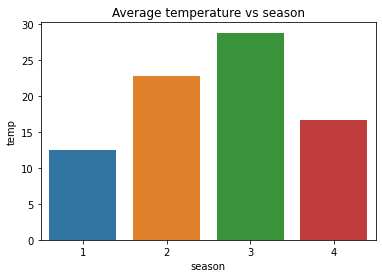

In [98]:
sns.barplot(data = temp_df, x = grouping_feature, y = "temp")
plt.title(f"Average temperature vs {grouping_feature}")
plt.show()

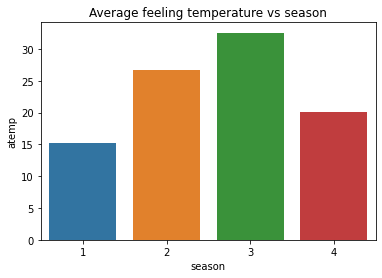

In [99]:
sns.barplot(data = temp_df, x = grouping_feature, y = "atemp")
plt.title(f"Average feeling temperature vs {grouping_feature}")
plt.show()

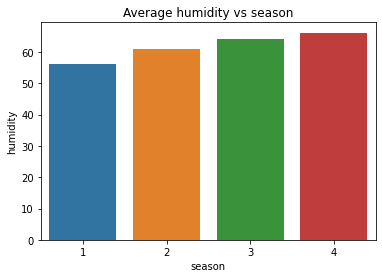

In [100]:
sns.barplot(data = temp_df, x = grouping_feature, y = "humidity")
plt.title(f"Average humidity vs {grouping_feature}")
plt.show()

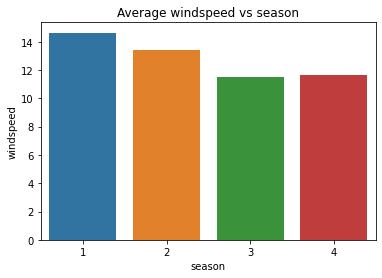

In [101]:
sns.barplot(data = temp_df, x = grouping_feature, y = "windspeed")
plt.title(f"Average windspeed vs {grouping_feature}")
plt.show()

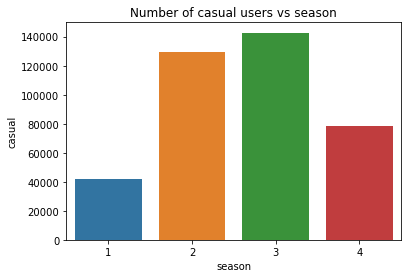

In [102]:
sns.barplot(data = temp_df, x = grouping_feature, y = "casual")
plt.title(f"Number of casual users vs {grouping_feature}")
plt.show()

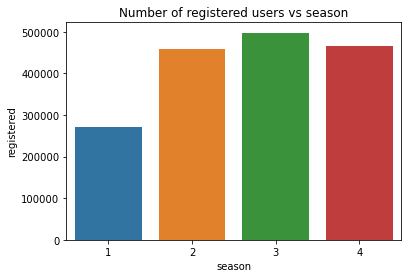

In [103]:
sns.barplot(data = temp_df, x = grouping_feature, y = "registered")
plt.title(f"Number of registered users vs {grouping_feature}")
plt.show()

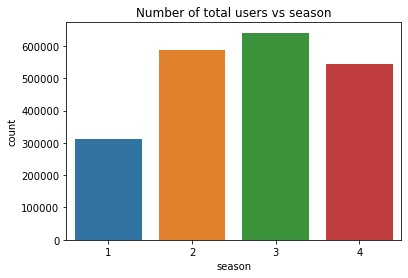

In [104]:
sns.barplot(data = temp_df, x = grouping_feature, y = "count")
plt.title(f"Number of total users vs {grouping_feature}")
plt.show()

### Group by holiday

In [105]:
grouping_feature = "holiday"

temp_df = df.groupby(grouping_feature).agg(agg_dict).reset_index()
temp_df

,holiday,temp,atemp,humidity,windspeed,casual,registered,count
0,0,20.230466,23.662662,61.880095,12.787623,376964,1650704,2027668
1,1,20.244244,23.397395,62.102894,13.199711,15171,42637,57808


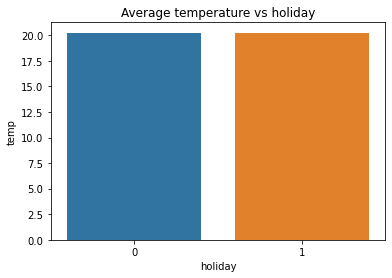

In [106]:
sns.barplot(data = temp_df, x = grouping_feature, y = "temp")
plt.title(f"Average temperature vs {grouping_feature}")
plt.show()

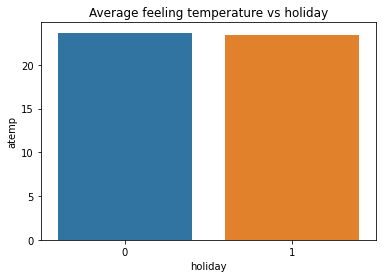

In [107]:
sns.barplot(data = temp_df, x = grouping_feature, y = "atemp")
plt.title(f"Average feeling temperature vs {grouping_feature}")
plt.show()

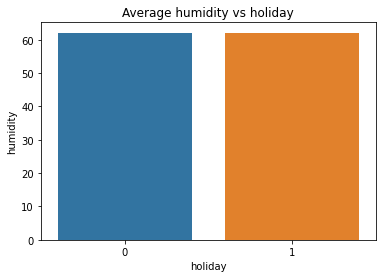

In [108]:
sns.barplot(data = temp_df, x = grouping_feature, y = "humidity")
plt.title(f"Average humidity vs {grouping_feature}")
plt.show()

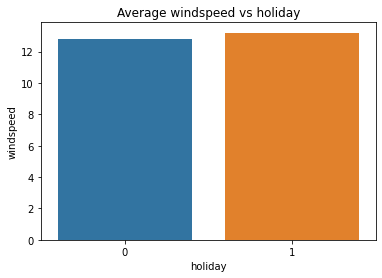

In [109]:
sns.barplot(data = temp_df, x = grouping_feature, y = "windspeed")
plt.title(f"Average windspeed vs {grouping_feature}")
plt.show()

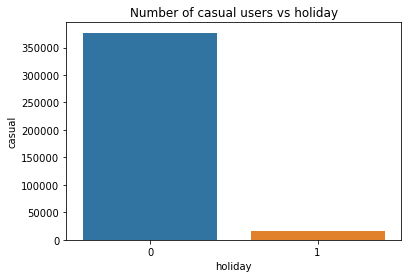

In [110]:
sns.barplot(data = temp_df, x = grouping_feature, y = "casual")
plt.title(f"Number of casual users vs {grouping_feature}")
plt.show()

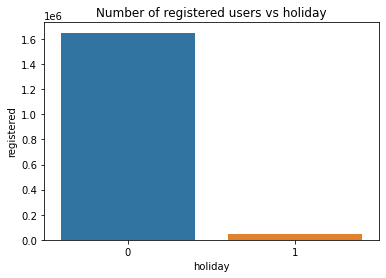

In [111]:
sns.barplot(data = temp_df, x = grouping_feature, y = "registered")
plt.title(f"Number of registered users vs {grouping_feature}")
plt.show()

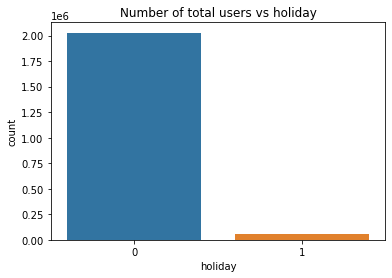

In [112]:
sns.barplot(data = temp_df, x = grouping_feature, y = "count")
plt.title(f"Number of total users vs {grouping_feature}")
plt.show()

### Group by workingday

In [113]:
grouping_feature = "workingday"

temp_df = df.groupby(grouping_feature).agg(agg_dict).reset_index()
temp_df

,workingday,temp,atemp,humidity,windspeed,casual,registered,count
0,0,19.889839,23.349837,62.192286,12.639916,206037,448835,654872
1,1,20.390696,23.798153,61.743119,12.874143,186098,1244506,1430604


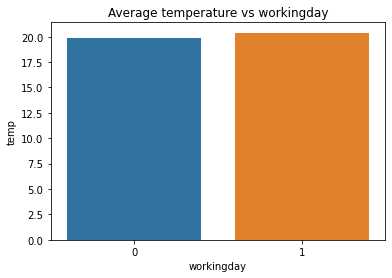

In [114]:
sns.barplot(data = temp_df, x = grouping_feature, y = "temp")
plt.title(f"Average temperature vs {grouping_feature}")
plt.show()

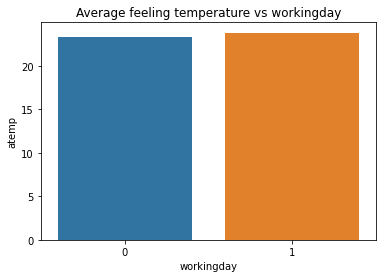

In [115]:
sns.barplot(data = temp_df, x = grouping_feature, y = "atemp")
plt.title(f"Average feeling temperature vs {grouping_feature}")
plt.show()

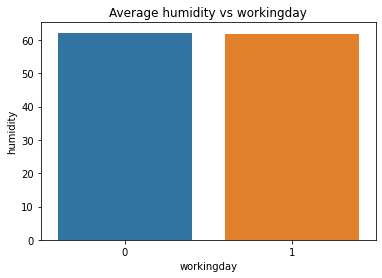

In [116]:
sns.barplot(data = temp_df, x = grouping_feature, y = "humidity")
plt.title(f"Average humidity vs {grouping_feature}")
plt.show()

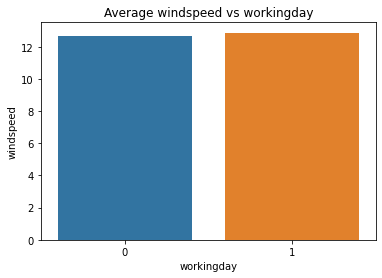

In [117]:
sns.barplot(data = temp_df, x = grouping_feature, y = "windspeed")
plt.title(f"Average windspeed vs {grouping_feature}")
plt.show()

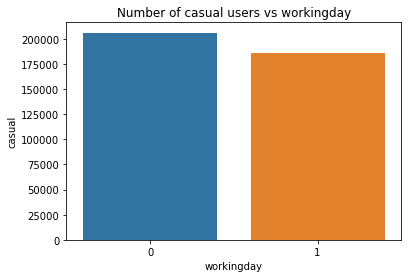

In [118]:
sns.barplot(data = temp_df, x = grouping_feature, y = "casual")
plt.title(f"Number of casual users vs {grouping_feature}")
plt.show()

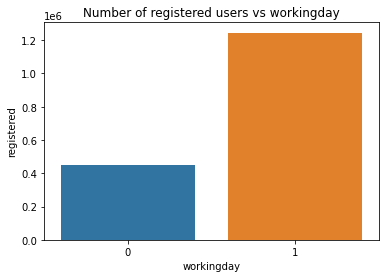

In [119]:
sns.barplot(data = temp_df, x = grouping_feature, y = "registered")
plt.title(f"Number of registered users vs {grouping_feature}")
plt.show()

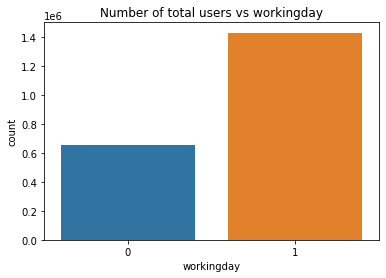

In [120]:
sns.barplot(data = temp_df, x = grouping_feature, y = "count")
plt.title(f"Number of total users vs {grouping_feature}")
plt.show()

### Group by weather

In [121]:
grouping_feature = "weather"

temp_df = df.groupby(grouping_feature).agg(agg_dict).reset_index()
temp_df

,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,1,20.557122,23.994126,56.716769,12.892542,289900,1186163,1476063
1,2,19.614608,23.072414,69.100565,12.179905,87246,419914,507160
2,3,19.546356,22.753091,81.341094,14.071248,14983,87106,102089
3,4,8.200000,11.365000,86.000000,6.003200,6,158,164


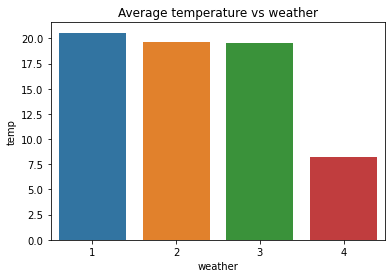

In [122]:
sns.barplot(data = temp_df, x = grouping_feature, y = "temp")
plt.title(f"Average temperature vs {grouping_feature}")
plt.show()

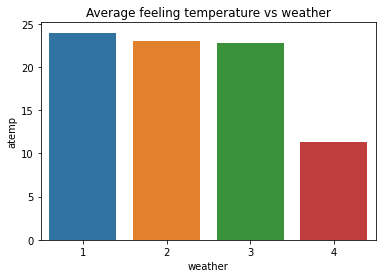

In [123]:
sns.barplot(data = temp_df, x = grouping_feature, y = "atemp")
plt.title(f"Average feeling temperature vs {grouping_feature}")
plt.show()

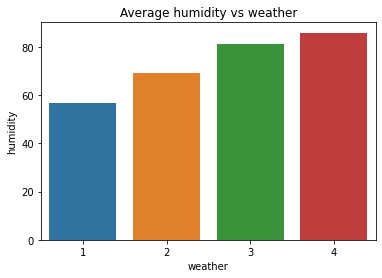

In [124]:
sns.barplot(data = temp_df, x = grouping_feature, y = "humidity")
plt.title(f"Average humidity vs {grouping_feature}")
plt.show()

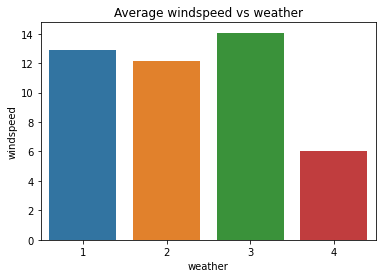

In [125]:
sns.barplot(data = temp_df, x = grouping_feature, y = "windspeed")
plt.title(f"Average windspeed vs {grouping_feature}")
plt.show()

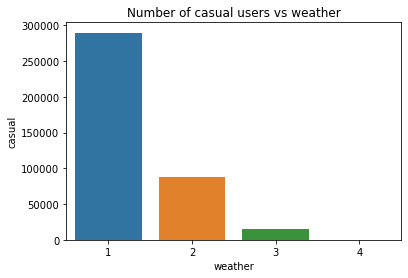

In [126]:
sns.barplot(data = temp_df, x = grouping_feature, y = "casual")
plt.title(f"Number of casual users vs {grouping_feature}")
plt.show()

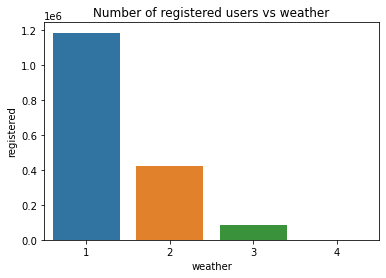

In [127]:
sns.barplot(data = temp_df, x = grouping_feature, y = "registered")
plt.title(f"Number of registered users vs {grouping_feature}")
plt.show()

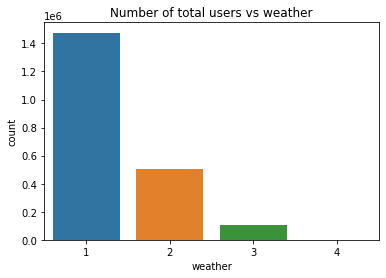

In [128]:
sns.barplot(data = temp_df, x = grouping_feature, y = "count")
plt.title(f"Number of total users vs {grouping_feature}")
plt.show()

### Group by year

In [129]:
grouping_feature = "year"

temp_df = df.groupby(grouping_feature).agg(agg_dict).reset_index()
temp_df

,year,temp,atemp,humidity,windspeed,casual,registered,count
0,2011,19.751988,23.157086,63.405017,12.924144,155817,626162,781979
1,2012,20.706051,24.149254,60.379575,12.675605,236318,1067179,1303497


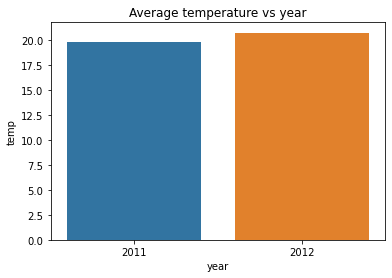

In [130]:
sns.barplot(data = temp_df, x = grouping_feature, y = "temp")
plt.title(f"Average temperature vs {grouping_feature}")
plt.show()

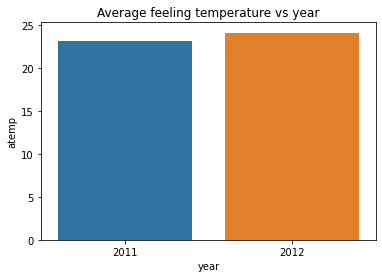

In [131]:
sns.barplot(data = temp_df, x = grouping_feature, y = "atemp")
plt.title(f"Average feeling temperature vs {grouping_feature}")
plt.show()

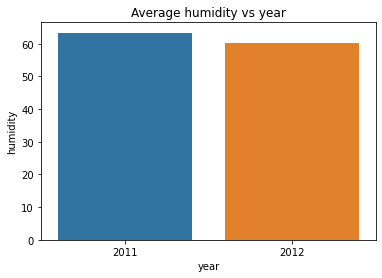

In [132]:
sns.barplot(data = temp_df, x = grouping_feature, y = "humidity")
plt.title(f"Average humidity vs {grouping_feature}")
plt.show()

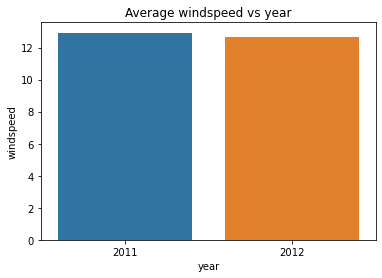

In [133]:
sns.barplot(data = temp_df, x = grouping_feature, y = "windspeed")
plt.title(f"Average windspeed vs {grouping_feature}")
plt.show()

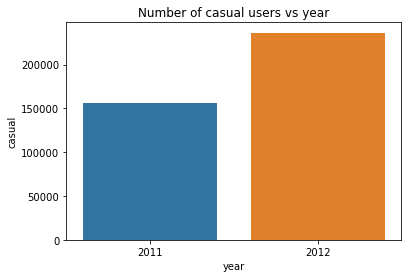

In [134]:
sns.barplot(data = temp_df, x = grouping_feature, y = "casual")
plt.title(f"Number of casual users vs {grouping_feature}")
plt.show()

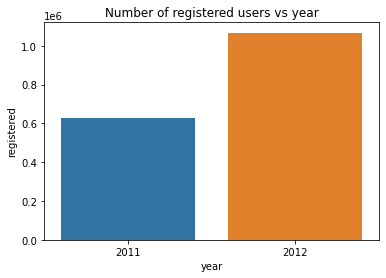

In [135]:
sns.barplot(data = temp_df, x = grouping_feature, y = "registered")
plt.title(f"Number of registered users vs {grouping_feature}")
plt.show()

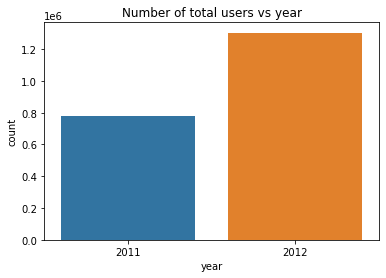

In [136]:
sns.barplot(data = temp_df, x = grouping_feature, y = "count")
plt.title(f"Number of total users vs {grouping_feature}")
plt.show()

### Group by month

In [137]:
grouping_feature = "month"

temp_df = df.groupby(grouping_feature).agg(agg_dict).reset_index()
temp_df

,month,temp,atemp,humidity,windspeed,casual,registered,count
0,1,9.840000,12.077579,55.911765,14.582959,7252,72632,79884
1,2,11.798535,14.532608,56.296337,13.963707,9297,89816,99113
2,3,15.902175,19.017220,56.678135,15.363249,25056,108445,133501
3,4,18.718372,22.305891,55.697470,15.581090,39813,127589,167402
4,5,22.674079,26.632374,68.084430,12.293956,41285,158862,200147
5,6,27.064496,30.988750,58.759868,12.348930,48574,172159,220733
6,7,30.841711,34.900395,58.402412,11.019928,50947,163670,214617
7,8,29.736689,33.122001,63.010965,11.931179,45870,167646,213516
8,9,25.779032,29.590248,70.980198,11.575698,45901,166628,212529
9,10,20.933853,24.739682,69.412733,11.226457,38087,169347,207434


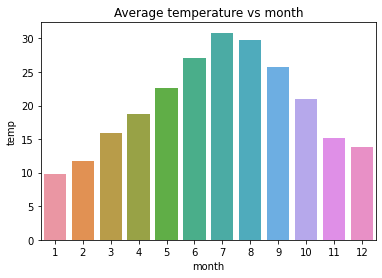

In [138]:
sns.barplot(data = temp_df, x = grouping_feature, y = "temp")
plt.title(f"Average temperature vs {grouping_feature}")
plt.show()

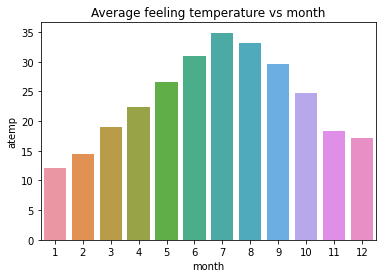

In [139]:
sns.barplot(data = temp_df, x = grouping_feature, y = "atemp")
plt.title(f"Average feeling temperature vs {grouping_feature}")
plt.show()

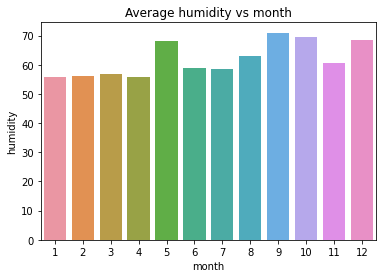

In [140]:
sns.barplot(data = temp_df, x = grouping_feature, y = "humidity")
plt.title(f"Average humidity vs {grouping_feature}")
plt.show()

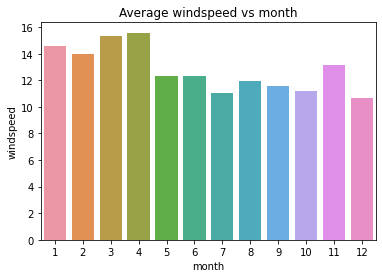

In [141]:
sns.barplot(data = temp_df, x = grouping_feature, y = "windspeed")
plt.title(f"Average windspeed vs {grouping_feature}")
plt.show()

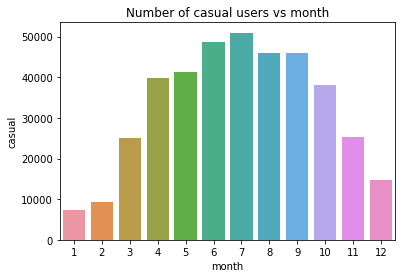

In [142]:
sns.barplot(data = temp_df, x = grouping_feature, y = "casual")
plt.title(f"Number of casual users vs {grouping_feature}")
plt.show()

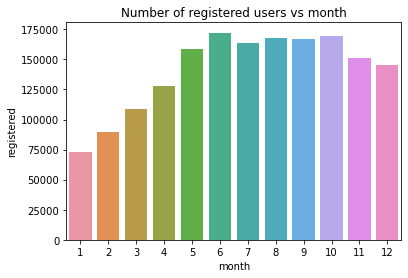

In [143]:
sns.barplot(data = temp_df, x = grouping_feature, y = "registered")
plt.title(f"Number of registered users vs {grouping_feature}")
plt.show()

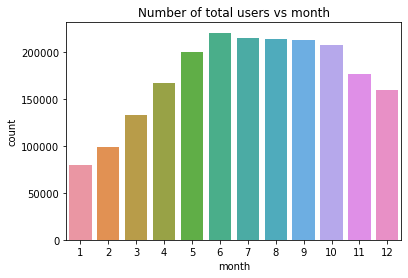

In [144]:
sns.barplot(data = temp_df, x = grouping_feature, y = "count")
plt.title(f"Number of total users vs {grouping_feature}")
plt.show()

### Group by week_day

In [145]:
grouping_feature = "week_day"

temp_df = df.groupby(grouping_feature).agg(agg_dict).reset_index()
temp_df

,week_day,temp,atemp,humidity,windspeed,casual,registered,count
0,0,20.620542,24.178507,62.508059,12.921691,46288,249008,295296
1,1,20.732307,24.252898,63.662768,13.338829,35365,256620,291985
2,2,20.323417,23.764271,64.299162,12.635379,34931,257295,292226
3,3,20.251835,23.641465,58.397939,13.138079,37283,269118,306401
4,4,19.993198,23.066609,59.913015,12.398527,47402,255102,302504
5,5,19.668611,23.121266,61.253157,12.670136,100782,210736,311518
6,6,20.041963,23.569766,63.151995,12.499344,90084,195462,285546


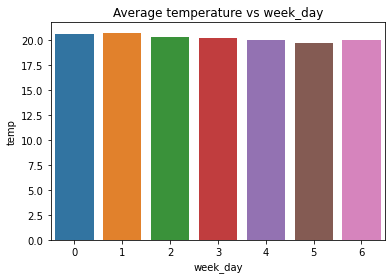

In [146]:
sns.barplot(data = temp_df, x = grouping_feature, y = "temp")
plt.title(f"Average temperature vs {grouping_feature}")
plt.show()

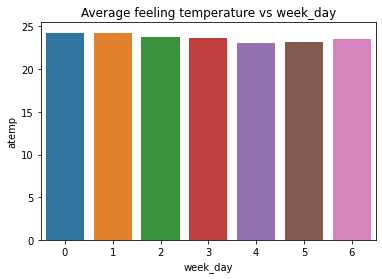

In [147]:
sns.barplot(data = temp_df, x = grouping_feature, y = "atemp")
plt.title(f"Average feeling temperature vs {grouping_feature}")
plt.show()

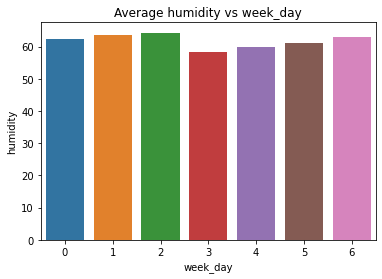

In [148]:
sns.barplot(data = temp_df, x = grouping_feature, y = "humidity")
plt.title(f"Average humidity vs {grouping_feature}")
plt.show()

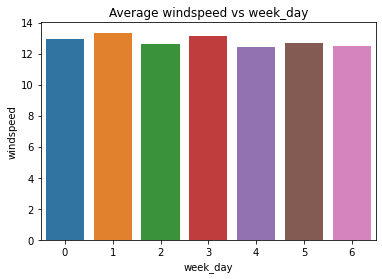

In [149]:
sns.barplot(data = temp_df, x = grouping_feature, y = "windspeed")
plt.title(f"Average windspeed vs {grouping_feature}")
plt.show()

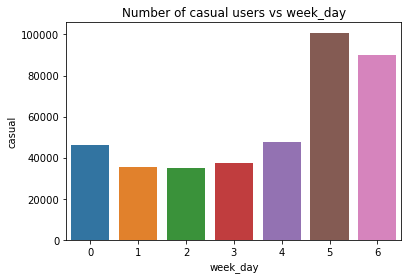

In [150]:
sns.barplot(data = temp_df, x = grouping_feature, y = "casual")
plt.title(f"Number of casual users vs {grouping_feature}")
plt.show()

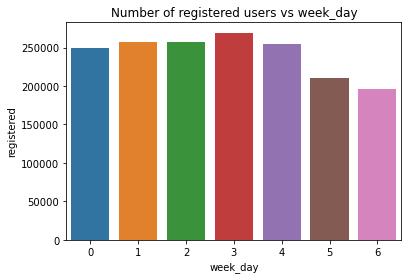

In [151]:
sns.barplot(data = temp_df, x = grouping_feature, y = "registered")
plt.title(f"Number of registered users vs {grouping_feature}")
plt.show()

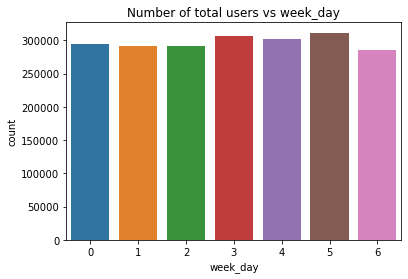

In [152]:
sns.barplot(data = temp_df, x = grouping_feature, y = "count")
plt.title(f"Number of total users vs {grouping_feature}")
plt.show()

### Group by time_of_day

In [153]:
grouping_feature = "time_of_day"

temp_df = df.groupby(grouping_feature).agg(agg_dict).reset_index()
temp_df

,time_of_day,temp,atemp,humidity,windspeed,casual,registered,count
0,Afternoon,22.780175,26.324441,49.853618,15.356595,134752,326737,461489
1,Evening,22.311283,25.778303,52.002741,15.373014,119014,579248,698262
2,Morning,19.112007,22.453147,66.417216,12.287123,79049,494111,573160
3,Night,19.035169,22.443822,68.010426,11.033622,59320,293245,352565


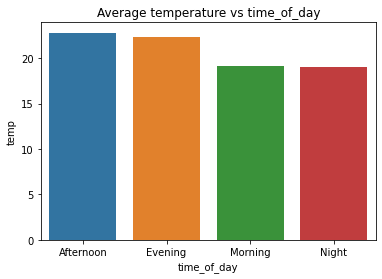

In [154]:
sns.barplot(data = temp_df, x = grouping_feature, y = "temp")
plt.title(f"Average temperature vs {grouping_feature}")
plt.show()

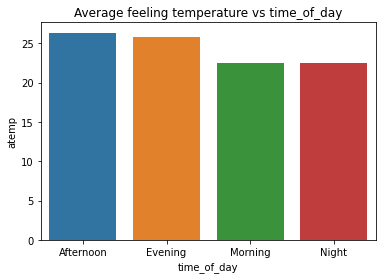

In [155]:
sns.barplot(data = temp_df, x = grouping_feature, y = "atemp")
plt.title(f"Average feeling temperature vs {grouping_feature}")
plt.show()

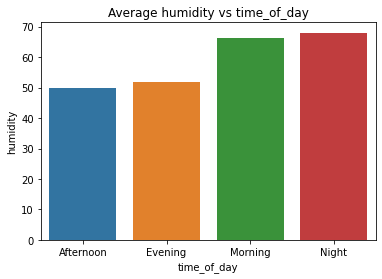

In [156]:
sns.barplot(data = temp_df, x = grouping_feature, y = "humidity")
plt.title(f"Average humidity vs {grouping_feature}")
plt.show()

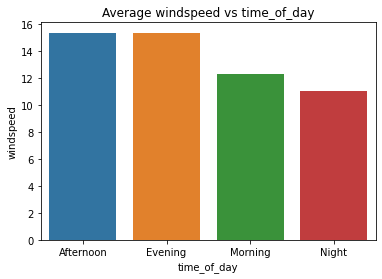

In [157]:
sns.barplot(data = temp_df, x = grouping_feature, y = "windspeed")
plt.title(f"Average windspeed vs {grouping_feature}")
plt.show()

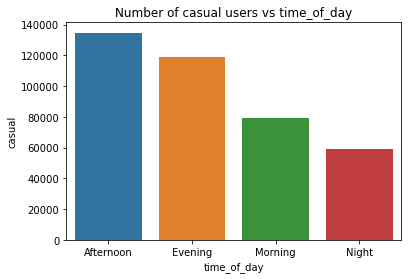

In [158]:
sns.barplot(data = temp_df, x = grouping_feature, y = "casual")
plt.title(f"Number of casual users vs {grouping_feature}")
plt.show()

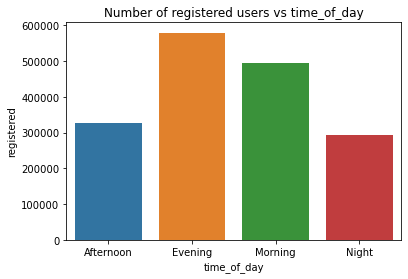

In [159]:
sns.barplot(data = temp_df, x = grouping_feature, y = "registered")
plt.title(f"Number of registered users vs {grouping_feature}")
plt.show()

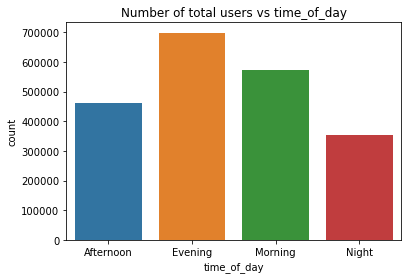

In [160]:
sns.barplot(data = temp_df, x = grouping_feature, y = "count")
plt.title(f"Number of total users vs {grouping_feature}")
plt.show()

## khjfdhjik

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     10886 non-null  datetime64[ns]
 1   season       10886 non-null  category      
 2   holiday      10886 non-null  category      
 3   workingday   10886 non-null  category      
 4   weather      10886 non-null  category      
 5   temp         10886 non-null  float64       
 6   atemp        10886 non-null  float64       
 7   humidity     10886 non-null  int64         
 8   windspeed    10886 non-null  float64       
 9   casual       10886 non-null  int64         
 10  registered   10886 non-null  int64         
 11  count        10886 non-null  int64         
 12  year         10886 non-null  category      
 13  month        10886 non-null  category      
 14  week         10886 non-null  category      
 15  week_day     10886 non-null  category      
 16  hour